In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc("font", size=18, family="serif")
import yt
import numpy as np
import matplotlib.pyplot as plt
from yt.utilities.physical_ratios import cm_per_kpc, K_per_keV
from yt.units import mp
import pyxsim

In [2]:
R = 1000. # radius of cluster in kpc
r_c = 100. # scale radius of cluster in kpc
rho_c = 1.673e-26 # scale density in g/cm^3
beta = 1. # beta parameter
kT = 4. # cluster temperature in keV
nx = 256
ddims = (nx,nx,nx)

In [3]:
x, y, z = np.mgrid[-R:R:nx*1j,
                   -R:R:nx*1j,
                   -R:R:nx*1j]
r = np.sqrt(x**2+y**2+z**2)

In [4]:
dens = np.zeros(ddims)
dens[r <= R] = rho_c*(1.+(r[r <= R]/r_c)**2)**(-1.5*beta)
dens[r > R] = 0.0
temp = kT*K_per_keV*np.ones(ddims)

In [5]:
data = {}
data["density"] = (dens, "g/cm**3")
data["temperature"] = (temp, "K")
data["velocity_x"] = (np.zeros(ddims), "cm/s")
data["velocity_y"] = (np.zeros(ddims), "cm/s")
data["velocity_z"] = (np.zeros(ddims), "cm/s")

bbox = np.array([[-0.5,0.5], [-0.5,0.5], [-0.5,0.5]])

ds = yt.load_uniform_grid(data, ddims, 2*R*cm_per_kpc, bbox=bbox)

yt : [INFO     ] 2016-08-05 19:46:31,633 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-08-05 19:46:31,634 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2016-08-05 19:46:31,635 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2016-08-05 19:46:31,636 Parameters: domain_right_edge         = [ 0.5  0.5  0.5]
yt : [INFO     ] 2016-08-05 19:46:31,638 Parameters: cosmological_simulation   = 0.0


The next thing we have to do is specify a derived field for the power-law emission. This could come from a variety of sources, for example, relativistic cosmic-ray electrons. For simplicity, we're not going to assume a specific model, except that we will only specify that the source of the power law emission is proportional to the gas mass in each cell:

In [6]:
norm = yt.YTQuantity(1.0e-19, "photons/s/keV")
def _power_law_emission(field, data):
    return norm*data["density"]*data["cell_volume"]/mp
ds.add_field(("gas","power_law_emission"), function=_power_law_emission, units="photons/s/keV")

where we have normalized the field arbitrarily. Note that the emission field for a power-law model is a bit odd in that it is technically a specific *luminosity* for the cell. This is done primarily for simplicity in designing the underlying algorithm.  

In [7]:
sp = ds.sphere("c", (0.5, "Mpc"))

In [8]:
A = yt.YTQuantity(500., "cm**2")
exp_time = yt.YTQuantity(1.0e5, "s")
redshift = 0.03

spec_model = pyxsim.XSpecThermalModel("bapec", 0.01, 80.0, 80000)
thermal_model = pyxsim.ThermalSourceModel(spec_model, Zmet=0.3)
plaw_model = pyxsim.PowerLawSourceModel(1.0, 0.01, 80.0, "power_law_emission", 1.0)

thermal_photons = pyxsim.PhotonList.from_data_source(sp, redshift, A, exp_time, thermal_model)
plaw_photons = pyxsim.PhotonList.from_data_source(sp, redshift, A, exp_time, plaw_model)

photons = thermal_photons + plaw_photons

pyxsim: [INFO     ] 2016-08-05 19:46:32,368 Cosmology: h = 0.71, omega_matter = 0.27, omega_lambda = 0.73
pyxsim: [INFO     ] 2016-08-05 19:46:32,379 Using emission measure field '(gas, emission_measure)'.
pyxsim: [INFO     ] 2016-08-05 19:46:32,381 Using temperature field '(gas, temperature)'.
Generating photons : 100%|██████████| 1099136/1099136 [01:11<00:00, 15479.99it/s]
pyxsim: [INFO     ] 2016-08-05 19:47:44,038 Finished generating photons.
pyxsim: [INFO     ] 2016-08-05 19:47:44,039 Number of photons generated: 3451211
pyxsim: [INFO     ] 2016-08-05 19:47:44,040 Number of cells with photons: 364911
pyxsim: [INFO     ] 2016-08-05 19:47:44,056 Cosmology: h = 0.71, omega_matter = 0.27, omega_lambda = 0.73
pyxsim: [INFO     ] 2016-08-05 19:47:48,122 Finished generating photons.
pyxsim: [INFO     ] 2016-08-05 19:47:48,123 Number of photons generated: 115431
pyxsim: [INFO     ] 2016-08-05 19:47:48,124 Number of cells with photons: 108798


In [9]:
nH_sim = 0.02
abs_model = pyxsim.XSpecAbsorbModel("TBabs", nH_sim)

In [10]:
events = photons.project_photons("x", absorb_model=abs_model)

pyxsim: [INFO     ] 2016-08-05 19:47:48,659 Absorbing.
pyxsim: [INFO     ] 2016-08-05 19:47:57,016 Total number of observed photons: 1016010
/Users/jzuhone/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [11]:
plaw_events = plaw_photons.project_photons("x", absorb_model=abs_model)

pyxsim: [INFO     ] 2016-08-05 19:47:57,756 Absorbing.
pyxsim: [INFO     ] 2016-08-05 19:48:07,924 Total number of observed photons: 66972


In [12]:
events.write_spectrum("all_spec.fits", bin_type="energy", emin=0.1, emax=80.0, nchan=8000, clobber=True)
plaw_events.write_spectrum("plaw_spec.fits", bin_type="energy", emin=0.1, emax=80.0, nchan=8000, clobber=True)

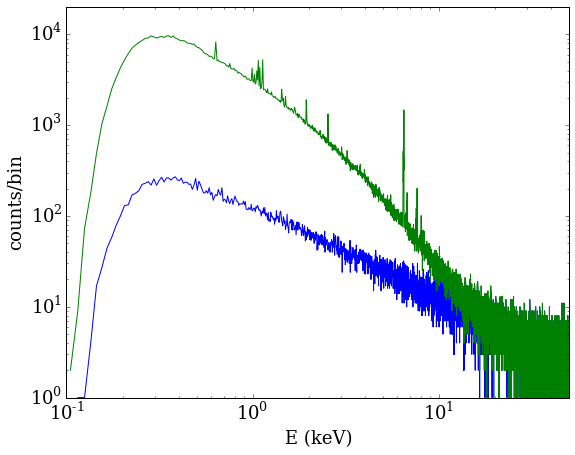

In [18]:
import astropy.io.fits as pyfits
f1 = pyfits.open("all_spec.fits")
f2 = pyfits.open("plaw_spec.fits")
plt.figure(figsize=(9,7))
plt.loglog(f2["SPECTRUM"].data["ENERGY"], f2["SPECTRUM"].data["COUNTS"])
plt.loglog(f1["SPECTRUM"].data["ENERGY"], f1["SPECTRUM"].data["COUNTS"])
plt.xlim(0.1, 50)
plt.ylim(1, 2.0e4)
plt.xlabel("E (keV)")
plt.ylabel("counts/bin")